# インポート

In [371]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pickle
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# データ取得

In [382]:
bike_df = pd.read_csv('../CSV/bike_all.csv')

In [383]:
df = pd.read_csv('../CSV/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('../CSV/test.csv', parse_dates=['datetime'])

In [384]:
# 学習のために型変換
def add_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

In [385]:
add_features(df)
add_features(df_test)

In [386]:
#  log1pの変換によってデータの分散が抑えられる
df["count"] = df["count"].map(np.log1p)

In [404]:
col = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek', 'hour']
col_test = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek', 'hour']

In [405]:
df = df.loc[:,col]

In [406]:
df_test = df_test.loc[:,col_test]

In [407]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4


In [408]:
X_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,count,count_pred
5912,1,0,1,2,17.22,21.210,77,0.0000,2012,2,2,3,13,4.927254,5.042995
6722,1,0,0,2,18.04,21.970,88,6.0032,2012,3,17,5,9,5.774552,5.578806
8754,3,0,1,1,28.70,33.335,84,0.0000,2012,8,7,1,3,1.945910,1.969150
7134,2,0,0,1,28.70,31.820,39,26.0027,2012,4,15,6,15,6.426488,6.446190
807,1,0,1,2,13.94,15.910,53,15.0013,2011,2,17,3,2,1.945910,1.858712


# データ分割

In [341]:
#目的変数の指定
objective = 'count'

In [342]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(df.drop(objective, axis=1), df[objective].ravel())

# パラメータチューニング

## max_depth & learning_rate

In [344]:
dtrain = xgb.DMatrix(X_train_validate.as_matrix(), label=y_train_validate.tolist())

/anaconda3/envs/python36_xgboost/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [243]:
fit_params = {
    'eval_metric': 'rmse',
    'eval_set': [[X_train_validate,y_train_validate]]
    }

In [249]:
#グリッドサーチの範囲
params = {
    'learning_rate': list(np.arange(0.05, 0.41, 0.05)),
    'max_depth': list(np.arange(3, 11, 1))
}

In [248]:
def GSfit(params):
    regressor = xgb.XGBRegressor(n_estimators=100)
    grid = GridSearchCV(regressor, params, cv=3, fit_params=fit_params, scoring='neg_mean_squared_error',verbose=2)
    grid.fit(X_train_validate,y_train_validate)
    
    return grid

In [ ]:
#Grid search
grid = GSfit(params)
grid_best_params = grid.best_params_
grid_scores_df = pd.DataFrame(grid.cv_results_)
grid_scores_df.to_csv('../CSV/grid_scores_' + name_param + '_' + str(num_hue) + '.csv', index=False)

## n_estimators

In [57]:
#best n by CV
cv=xgb.cv(grid_best_params, dtrain, num_boost_round=200, nfold=3)
n_best = cv[cv['test-rmse-mean'] == cv['test-rmse-mean'].min()]['test-rmse-mean'].index[0]
grid_best_params['n_estimators'] = n_best + 1
pd.io.json.json_normalize(grid_best_params).to_csv('../CSV/param_best_part_' +'.csv', index=False)

# 学習

In [58]:
#fit by best params
regressor = xgb.XGBRegressor(learning_rate=grid_best_params['learning_rate'],
                             max_depth=grid_best_params['max_depth'], 
                             n_estimators=grid_best_params['n_estimators'])
regressor.fit(X_train_validate, y_train_validate, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=175,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [230]:
#save model
pickle.dump(regressor, open('model.pkl', 'wb'))

# 予測

In [345]:
# prediction
result = regressor.predict(X_test)
X_test[objective] = y_test
X_test[objective + '_pred'] = result

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x124dc02b0>>
Traceback (most recent call last):
  File "/anaconda3/envs/python36_xgboost/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x12229dc50>>
Traceback (most recent call last):
  File "/anaconda3/envs/python36_xgboost/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


# 誤差率計算

In [346]:
# Metric Use By Kaggle
def compute_rmsle(y_true, y_pred):
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
        
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
     
    return(np.average((np.log1p(y_pred) - np.log1p(y_true))**2)**.5)

In [347]:
print("RMSE: {0}".format(metrics.mean_squared_error(X_test['count'].map(np.expm1),X_test['count_pred'].map(np.expm1))**.5))

RMSE: 28.00224160523523


In [348]:
print("RMSLE: {0}".format(compute_rmsle(X_test['count'].map(np.expm1),X_test['count_pred'].map(np.expm1))))

RMSLE: 0.19849824353736945


# 可視化

In [349]:
name = 'bike'

## rmse-valid-train

<IPython.core.display.Javascript object>


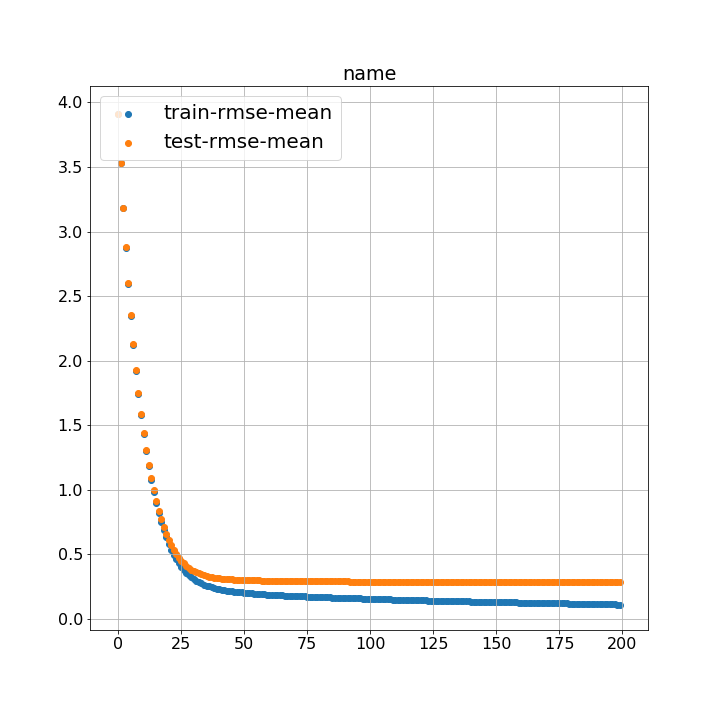

In [350]:
plt.rcParams["font.size"] = 16 #フォントサイズの指定
fig = plt.figure(figsize=(10,10)) #図の生成
ax = fig.add_subplot(1,1,1) #軸の指定

plt.grid(True)

ax.scatter(cv.index, cv['train-rmse-mean']) #データのプロット
ax.scatter(cv.index, cv['test-rmse-mean']) #データのプロット
#ax.plot(x,x)
ax.set_xlim([None, None]) #x軸の範囲
ax.set_ylim([None, None]) #y軸の範囲

ax.set_title('name') #グラフのタイトル
#ax.set_xlabel(objective) #x軸の名前
#ax.set_ylabel(objective_pred) #y軸の名前

ax.legend(loc='upper left', fontsize=20) #凡例の表示
plt.savefig('../Graph/' + 'name' +  '_'  + '_rmse-train-valid.png', bbox_inches="tight")
plt.show()

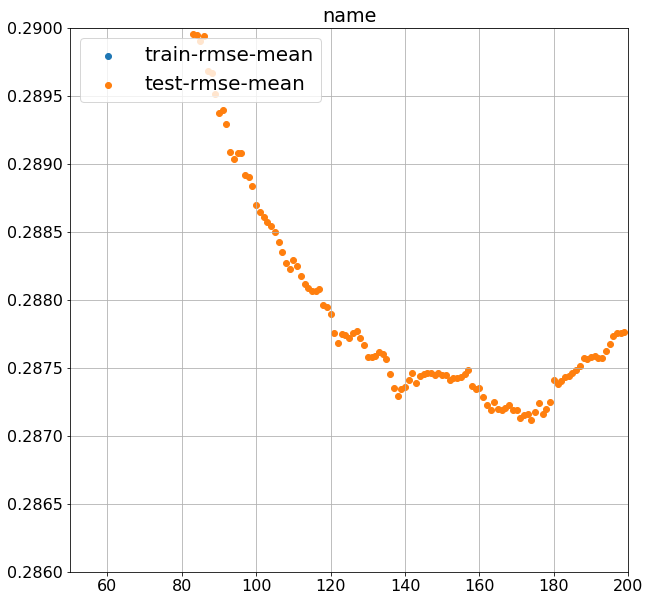

In [257]:
plt.rcParams["font.size"] = 16 #フォントサイズの指定
fig = plt.figure(figsize=(10,10)) #図の生成
ax = fig.add_subplot(1,1,1) #軸の指定

plt.grid(True)

#ax.scatter(cv.index, cv['train-rmse-mean']) #データのプロット
ax.scatter(cv.index, cv['test-rmse-mean']) #データのプロット
#ax.plot(x,x)
ax.set_xlim([50, 200]) #x軸の範囲
ax.set_ylim([0.286, 0.29]) #y軸の範囲

ax.set_title('name') #グラフのタイトル
#ax.set_xlabel(objective) #x軸の名前
#ax.set_ylabel(objective_pred) #y軸の名前

ax.legend(loc='upper left', fontsize=20) #凡例の表示
plt.savefig('../Graph/' + 'name' +  '_'  + 'rmse-train-valid-focus.png', bbox_inches="tight")
plt.show()

## Feature importance

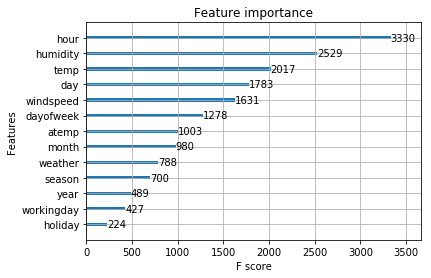

In [372]:
xgb.plot_importance(regressor)

## Box plot

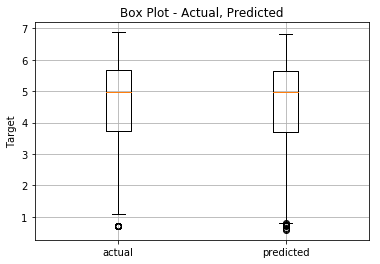

In [373]:
plt.boxplot([X_test['count'],X_test['count_pred']], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

## Training Data Residuals

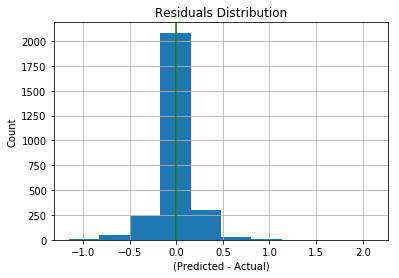

In [374]:
#過少予測と過大予測
residuals = (X_test['count_pred'] - X_test['count'])

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

## 散布図

<IPython.core.display.Javascript object>


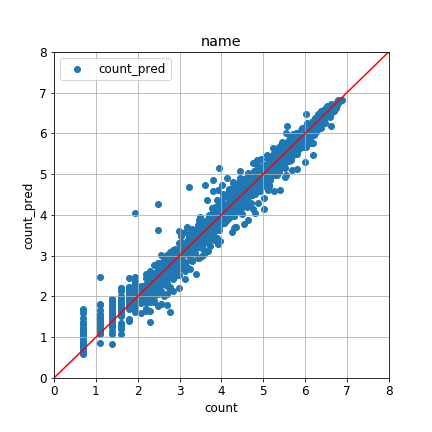

In [423]:
plt.rcParams["font.size"] = 12 #フォントサイズの指定
fig = plt.figure(figsize=(6,6)) #図の生成
ax = fig.add_subplot(1,1,1) #軸の指定

plt.grid(True)

ax.scatter(X_test[objective], X_test[objective + '_pred']) #データのプロット
x = np.arange(0, 10, 0.1)
ax.plot(x,x, color='red')
ax.set_xlim([0, 8]) #x軸の範囲
ax.set_ylim([0, 8]) #y軸の範囲


ax.set_title('name') #グラフのタイトル
ax.set_xlabel(objective) #x軸の名前
ax.set_ylabel(objective + '_pred') #y軸の名前

ax.legend(loc='upper left') #凡例の表示
plt.savefig('../Graph/' + 'name' +  '_'  + '_scatter.png', bbox_inches="tight")
plt.show()

## 3Dプロット

In [366]:
max_depth = grid_scores_df['param_max_depth'].ravel()
learning_rate = grid_scores_df['param_learning_rate'].ravel()
rmse_valid = grid_scores_df['mean_test_score'].ravel() * -1

In [367]:
param_pivot = grid_scores_df.pivot_table(index=['param_max_depth'], columns=['param_learning_rate'], values=['mean_test_score']) * -1

In [368]:
X = param_pivot.index.ravel()
Y = param_pivot['mean_test_score'].columns.ravel()
X,Y=np.meshgrid(X,Y)
Z=param_pivot.T.values

In [418]:
% matplotlib notebook

<IPython.core.display.Javascript object>


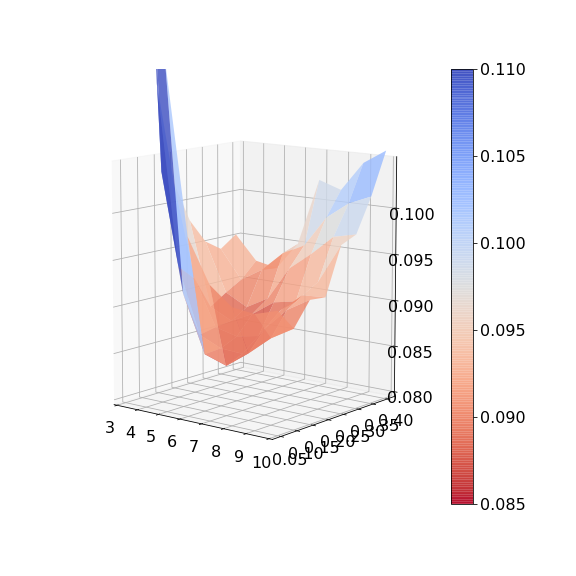

In [419]:
#パラメータとvalidation errorの関係
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

ax.set_xlim(3, 10)
ax.set_zlim(0.08, 0.105)

surf = ax.plot_surface(X,Y,Z, alpha=0.8, cmap=cm.coolwarm_r, linewidth=1, vmin=0.085, vmax=0.11)
fig.colorbar(surf)

plt.show()

## ヒートマップ

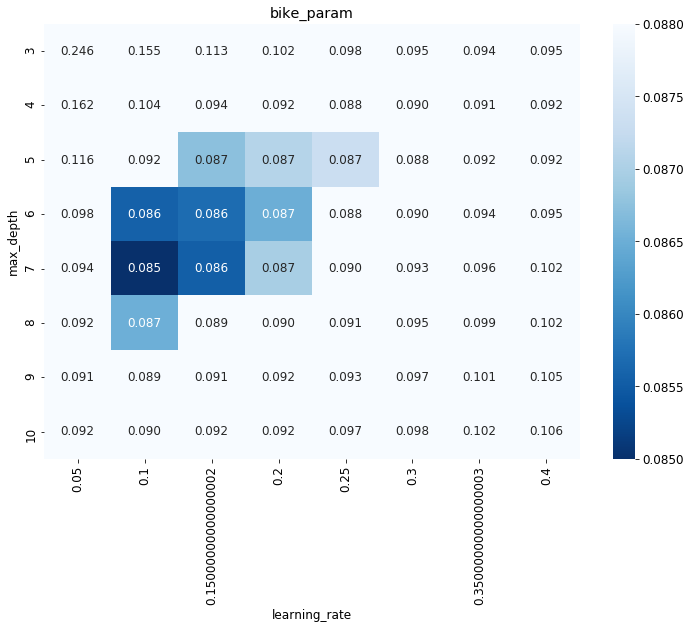

In [375]:
#パラメータとvalidation errorの関係
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(12,8)) #図の生成
ax = fig.add_subplot(1,1,1) #軸の指定

sns.heatmap(param_pivot.loc[:,'mean_test_score'],
            ax=ax, vmin=0.085, vmax=0.088, annot=True, fmt="1.3f", cmap='Blues_r')

#ax.set_label()
ax.set_title(name + '_' + 'param') #グラフのタイトル
ax.set_xlabel('learning_rate') #x軸の名前
ax.set_ylabel('max_depth') #y軸の名前
 
plt.savefig('../Graph/' + name + '_heatmap.png', bbox_inches="tight")
plt.show() #グラフの表示

In [413]:
predict = regressor.predict(df_test)

In [414]:
predict_df = pd.DataFrame(predict)

In [416]:
predict_df.to_csv('../CSV/predict.csv', index=False)